In [2]:
import sys
sys.path.append('../')
import ressource.utils as utils
from ressource.utils import read_file_and_create_graph, visualize_paths, Graph

In [3]:
import os

# Get the current working directory
current_path = os.getcwd()

# Go up one directory to the parent directory
parent_path = os.path.abspath(os.path.join(current_path, os.pardir))

# Construct the path to the 'data' directory
data_path = os.path.join(parent_path, 'data')

# Get a list of all items (files and folders) in the 'data' directory
all_items = os.listdir(data_path)

# Filter the items to include only folders that start with "Set"
set_folders = [item for item in all_items if os.path.isdir(os.path.join(data_path, item)) and item.startswith('Set')]
data_paths=[]
for folder in set_folders:
    data_paths.append(os.path.join(data_path, folder))


In [4]:
directory_path=data_paths[0]
all_items = os.listdir(directory_path)
txt_files = [os.path.join(directory_path, item) for item in all_items if os.path.isfile(os.path.join(directory_path, item)) and item.endswith('.txt')]

In [5]:
print(txt_files[0])
graph_object = read_file_and_create_graph(txt_files[0])

/Users/omarelloumi/Desktop/Projects/TOP_Resolution/src/data/Set_32_234/p1.3.m.txt


genetic representation
Fitness function
genome
crossover => cross two solution and get a better one 
mutation => change a random bit in genome with a certain probability

In [6]:
def farthest_insertion(points, starting_point, ending_point):
    """Heuristique d'insertion du plus point le plus lointain pour le TSP."""
    n = len(points)

    pts = [point for point in points]
    # Choix arbitraire de deux points comme points de départ
    tour = [starting_point, ending_point]

    pts.pop(pts.index(starting_point)) # suppression de points[0]
    pts.pop(pts.index(ending_point)) # suppression de points[1]


    while len(pts) > 0 :
        # Trouver le point le plus éloigné
        max_dist = -1
        farthest_point = (0, 0)
        pt_tour = (0,0)
        for i in range(len(pts)):
            for point_tour in tour:
                if utils.distance(pts[i], point_tour) > max_dist:
                    max_dist = utils.distance(pts[i], point_tour)
                    farthest_point = pts[i]
                    pt_tour = point_tour

        # Trouver l'arête du tour actuel qui minimise l'ajout de longueur
        min_insertion_cost = float('inf')
        insert_index = 0
        for i in range(len(tour) - 1):
            # Variation de coût d'introduction du point le plus loin entre 2 noeuds
            d = utils.distance(tour[i], farthest_point) + utils.distance(farthest_point, tour[i + 1]) - utils.distance(tour[i],tour[i + 1])

            # Minimisation de la variation
            if d < min_insertion_cost:
                min_insertion_cost = d
                insert_index = i + 1

        # Insérer le point le plus éloigné à l'emplacement identifié
        tour.insert(insert_index, farthest_point)
        pts.pop(pts.index(farthest_point))

    return tour

In [7]:
"""Algorithme de Beasley pour le TOP"""
starting_point=graph_object.getNodes()[0]
ending_point=graph_object.getNodes()[-1]
heuristic_path = farthest_insertion(graph_object.getNodes(),starting_point,ending_point)
convoy = []
paths = []
# On supprime les noeuds de départ et d'arrivée. Ils seront automatiquement ajouté dans un chemin
heuristic_path.pop(heuristic_path.index(starting_point))
heuristic_path.pop(heuristic_path.index(ending_point))
for i in range(len(heuristic_path)):
    path = [starting_point, ending_point]
    j = i
    prev_node_idx = 0
    continue_insertion = True
    while continue_insertion:
        path.insert(prev_node_idx+1,heuristic_path[j])
        #print(path,calculate_profit(path,graph.profits),calculate_time(path,graph.times))
        duration = utils.calculate_time(path,graph_object.times)
        if duration <= graph_object.maxTime :
            paths.append([node for node in path])
            # Si le chemin passant par ce noeud ne dépasse pas tmax, on peut l'ajouter au convoi si son profit est meilleur que les autres chemins
            prev_node_idx += 1
            j+=1
            if j>=len(heuristic_path):
                # Si on a déjà étudié le dernier noeud, on s'arrête
                continue_insertion = False
        else :
            # Si tmax dépassé, on ne tente plus d'insertion
            continue_insertion = False
solution,profits = utils.generate_convoy(graph_object.nbVehicules, paths, graph_object.profits)

In [8]:
print(solution)

([(10.5, 14.4), (11.2, 17.6), (15.0, 17.9), (16.4, 17.8), (16.1, 19.6), (15.7, 20.6), (13.2, 20.1), (11.7, 20.3), (11.2, 14.1)], [(10.5, 14.4), (8.2, 19.9), (8.7, 17.7), (7.3, 18.8), (4.9, 18.9), (8.9, 13.6), (11.2, 14.1)], [(10.5, 14.4), (7.9, 9.8), (8.3, 5.0), (11.4, 6.7), (11.2, 14.1)])


In [12]:
import random

class GeneticAlgorithm:
    def __init__(self, graph : Graph, population_size, generations):
        self.graph = graph
        self.population_size = population_size
        self.generations = generations
        self.population = self.initialize_population()
        print(len(self.population))
        print("population: ",self.population)

    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            route = random.sample(self.graph.getNodes(), len(self.graph.getNodes()))
            population.append(route)

        population=self.repair_solution(population) 
        grouped_list = []
        for i in range(0, len(population), graph_object.nbVehicules):
            group = population[i:i+graph_object.nbVehicules]
            grouped_list.append(group)

        # !!!!! #need verify that all routes are different (doesn't have similar nodes)
        return grouped_list
    
    def repair_solution(self,population):
        solution=[]
        #print(self.graph.getMaxTime())
        #print(self.fitness_function(population))
        for route in population:
            total_time = 0
            # we remove start and end to not compare the same nodes
            if self.graph.start_point in route:
                route.remove(self.graph.start_point)
            if self.graph.end_point in route:
                route.remove(self.graph.end_point)
            repaired_route = [self.graph.start_point]
            i=0
            for node in route:
                if total_time + self.graph.getTimes()[(repaired_route[i], node)] <= self.graph.getMaxTime():
                    repaired_route.append(node)
                    total_time += self.graph.getTimes()[(repaired_route[i], node)]
                    #print((repaired_route[i], node)," ",total_time)
                    i+=1
            while repaired_route and (total_time + self.graph.getTimes()[(repaired_route[-1],self.graph.end_point)])>self.graph.getMaxTime():
                #print("A ",( repaired_route[-1],self.graph.end_point)," ",(total_time + self.graph.getTimes()[(repaired_route[-1],self.graph.end_point)]))
                a=repaired_route.pop()
                #print(self.graph.getTimes()[(repaired_route[-1],a)])
                total_time-=self.graph.getTimes()[(repaired_route[-1],a)]
            repaired_route.append(self.graph.end_point)
            solution.append(repaired_route)
        #print(self.fitness_function(solution))
        if len(solution)>0:
            self.unique_nodes(solution)
        #print(self.fitness_function(solution))
        #print(self.fitness_function(solution))
        return solution
    ##############################################################################################################################################
    
    def fitness_function(self,convoy):
        total_profit = 0
        for path in convoy:
            total_time = 0
            #print("path ",path)
            for i in range(len(path) - 1):
                current_node = path[i]
                next_node = path[i + 1]
                #print((current_node,next_node))
                # Assuming getProfits() takes nodes as arguments
                #print(current_node)
                profit = self.graph.getProfits()[current_node]

                # Check if adding the next node exceeds the time limit
                if current_node!=next_node and total_time + self.graph.getTimes()[(current_node, next_node)] <= self.graph.getMaxTime():
                    total_profit += profit
                    total_time += self.graph.getTimes()[(current_node, next_node)]
                else:
                    # Return 0 if time limit is exceeded
                    return 0

            # Add profit for the last node (if needed)
            total_profit += self.graph.getProfits()[path[-1]]
        return total_profit
    
    def calculate_time(self,convoy):
        total_time = []
        for path in convoy:
            time=0
            for i in range(len(path) - 1):
                current_node = path[i]
                next_node = path[i + 1]
                time+=self.graph.getTimes()[(current_node, next_node)]
            total_time.append(time)
        return total_time
    
    def selection(self, tournament_size):
        candidates = []
        for _ in range(tournament_size):
            candidates.append(random.sample(self.population, tournament_size))
        #print("len(candidates) ",len(candidates))
        #print("candidates[Ø] ",candidates[0][0])
        #print("candidates ",candidates)
        filtered=[sublist for sublist in candidates[0] if len(sublist)>0]
        selected_candidate = max(filtered, key=self.fitness_function)
        print(selected_candidate)
        selected_candidate = max(selected_candidate,key=len)
        return selected_candidate

    def mutation(self, convoy):
        mutated_convoy = []
        for path in convoy:
            # Choose a random mutation point for each path
            mutation_point = random.randint(0, len(path) - 1)
            # Use set difference to find nodes that are not in the current path
            remaining_nodes = set(list(self.graph.getNodes())) - set(path)
            # Replace the node at the mutation point with a random remaining node
            mutated_path = path[:mutation_point] + [random.choice(list(remaining_nodes))] + path[mutation_point + 1:]
            #print("mutated=",mutated_path)
            mutated_convoy.append(self.unique_list(mutated_path))
        return mutated_convoy
    
    def crossover(self,parent1, parent2):
        # Initialize the child with an empty list of paths
        child = []
        
        start_point = parent1[0]
        end_point = parent1[-1]
        print(parent1)
        print(parent2)
        p1=parent1[1:-1]
        p2=parent2[1:-1]
        # Iterate through each pair of paths in the parents
        for path1, path2 in zip(p1, p2):
            # Choose a random crossover point for each path
            crossover_point = random.randint(0, min(len(path1), len(path2)))
            # Combine the first part of path1, crossover part of path2, and the second part of path1
            #print(parent1[:crossover_point])
            #print(parent1[crossover_point:])
            #print([point for point in parent2 if point not in parent1])
            new_path=[]
            if len(p1[:crossover_point])>0:
                new_path+=(p1[:crossover_point])
            for point in p2:
                if point not in p1:
                    #print(point)
                    new_path.append(point)
            if len(p1[crossover_point:])>0:
                new_path+=(p1[crossover_point:])
            #new_path = list(path1[:crossover_point]) + [(point) for point in path2 if point not in path1] + list(path1[crossover_point:])
            
            # Put back the start and end points
            new_path.insert(0, start_point)
            new_path.append(end_point)
            #print(self.fitness_function(new_path))
            #print("new=",new_path)
            # Ensure that the same tuples are not repeated
            child.append(self.unique_list(new_path))
        return child
    
    def unique_list(self,convoy):
        unique_second_elements = set()
        # Filter the original list to keep only tuples with unique second elements
        filtered_list = [item for item in convoy if item[1] not in unique_second_elements and not unique_second_elements.add(item[1])]
        return filtered_list
    
    def unique_nodes(self,convoy):
        print("before ",convoy)
        for i,subset in enumerate(convoy):
            for k,node in enumerate(subset[1:-1]):
                for j in range(len(convoy)):
                    if j!=i:
                        if node in convoy[j]:
                            convoy[i][k+1]=random.choice(self.graph.nodes)
        print("after ",convoy)
    def sorting_key(self, path):
        profit = 0
        for i in range(1,len(path) - 1):
                current_node = path[i]
                profit+=self.graph.getProfits()[current_node]
        sequence_length = len(path)
        return (profit, sequence_length)

    def evolve(self, elitism_ratio=0.1):
        # Calculate the number of individuals to be preserved via elitism
        num_elites = max(1, int(self.population_size * elitism_ratio))
        for generation in range(self.generations):
            new_population = []
            #
            fitness_values = []
            for individual in self.population:
                #print("indiv ",individual)
                fitness_values.append((individual, self.fitness_function(individual)))
            sorted_population = sorted(fitness_values, key=lambda x: x[1], reverse=True)
            #print("sorted: ",sorted_population)
            #
            elites = [individual for individual, _ in sorted_population[:num_elites]]
            # Perform elitism by selecting the top solutions
            #elites = sorted(self.population, key=self.fitness_function, reverse=True)[:num_elites]
            new_population.extend(elites)

            # Generate offspring using crossover and mutation
            for _ in range((self.population_size - num_elites) // 2):
                #print("YESSSS" , _)
                parent1 = self.selection(3)
                parent2 = self.selection(3)
                child1 = self.crossover(parent1, parent2)
                child2 = self.crossover(parent2, parent1)

                child1 = self.repair_solution(self.mutation(child1))
                child2 = self.repair_solution(self.mutation(child2))
                new_population.extend([child1, child2])

            self.population = new_population

            # Optional: Print or store the best solution in each generation
            best_solution = max(self.population, key=self.fitness_function)
            sorted_elements = sorted(best_solution, key=self.sorting_key, reverse=True)
            # Select the top 3 elements
            best_n_elements = sorted_elements[:self.graph.nbVehicules]
            print(f"Generation {generation + 1}, Best Solution: {best_n_elements}, Fitness: {self.fitness_function(best_solution)}", "Time: ",self.calculate_time(best_n_elements))
        return (best_n_elements)
    
ga = GeneticAlgorithm(graph_object, population_size=20*graph_object.nbVehicules, generations=50)
ga.evolve()
#ga.unique_nodes([[(8.2, 19.9), (7.4, 24.0), (10.1, 26.4), (9.7, 23.8), (10.2, 22.1), (11.7, 20.3), (8.7, 17.7), (7.3, 18.8)], [(8.2, 19.9), (7.4, 24.0), (10.1, 26.4), (9.7, 23.8), (10.2, 22.1), (11.7, 20.3), (8.7, 17.7), (7.3, 18.8)], [(8.2, 19.9), (7.4, 24.0), (10.1, 26.4), (9.7, 23.8), (10.2, 22.1), (11.7, 20.3), (8.7, 17.7), (7.3, 18.8)]])


before  [[(14.3, 15.3), (5.6, 11.1), (11.4, 12.0)], [(14.3, 15.3), (16.3, 13.3), (11.7, 20.3), (11.4, 12.0)], [(14.3, 15.3), (7.3, 18.8), (14.9, 13.2), (11.4, 12.0)], [(14.3, 15.3), (15.4, 11.0), (11.2, 14.1), (7.9, 9.8), (11.4, 12.0)], [(14.3, 15.3), (16.3, 13.3), (15.4, 11.0), (8.7, 17.7), (11.4, 12.0)], [(14.3, 15.3), (14.0, 5.1), (11.4, 12.0)], [(14.3, 15.3), (11.2, 17.6), (15.0, 17.9), (11.7, 20.3), (11.4, 12.0)], [(14.3, 15.3), (10.5, 14.4), (5.6, 11.1), (11.4, 12.0)], [(14.3, 15.3), (10.2, 22.1), (11.4, 12.0)], [(14.3, 15.3), (14.0, 5.1), (11.4, 12.0)], [(14.3, 15.3), (10.1, 18.7), (11.4, 12.0)], [(14.3, 15.3), (15.7, 20.6), (8.2, 19.9), (11.4, 12.0)], [(14.3, 15.3), (7.3, 18.8), (8.7, 17.7), (11.4, 12.0)], [(14.3, 15.3), (4.9, 18.9), (11.4, 12.0)], [(14.3, 15.3), (15.0, 17.9), (11.4, 6.7), (11.4, 12.0)], [(14.3, 15.3), (15.0, 17.9), (15.7, 20.6), (16.4, 17.8), (10.5, 14.4), (11.4, 12.0)], [(14.3, 15.3), (8.7, 17.7), (11.4, 12.0)], [(14.3, 15.3), (16.3, 13.3), (10.5, 14.4), (5.6

[[(14.3, 15.3), (10.1, 18.7), (8.2, 19.9), (8.9, 13.6), (11.4, 12.0)],
 [(14.3, 15.3), (16.5, 9.3), (11.4, 6.7), (11.4, 12.0)],
 [(14.3, 15.3), (18.3, 13.3), (15.4, 11.0), (11.4, 12.0)]]

In [10]:
import random

class GeneticAlgorithm:
    def __init__(self, graph : Graph, population_size, generations):
        self.graph = graph
        self.population_size = population_size
        self.generations = generations
        self.population = self.initialize_population()

    def initialize_population(self):
        population = []
        for _ in range(self.population_size):
            route = random.sample(self.graph.getNodes(), len(self.graph.getNodes()))
            population.append(route)
        return population


    def fitness_function(self, convoy):
        total_profit = 0

        for path in convoy:
            total_time = 0
            for i in range(len(path) - 1):
                current_node = path[i]
                next_node = path[i + 1]

                # Assuming getProfits() takes nodes as arguments
                profit = self.graph.getProfits()[current_node]

                # Check if adding the next node exceeds the time limit
                if total_time + self.graph.getTimes()[(current_node, next_node)] <= self.graph.getMaxTime():
                    total_profit += profit
                    total_time += self.graph.getTimes()[(current_node, next_node)]
                else:
                    # Return 0 if time limit is exceeded
                    return 0

            # Add profit for the last node (if needed)
            total_profit += self.graph.getProfits()[path[-1]]

        return total_profit

    

    def tournament_selection(self, tournament_size):
        tournament_candidates_indices = random.sample(range(len(self.population)), tournament_size)
        best_candidate_index = max(tournament_candidates_indices, key=lambda idx: self.fitness_function(self.population[idx]))
        return self.population[best_candidate_index]


    def selection(self, tournament_size):
        candidates = random.sample(self.population, tournament_size)
        selected_path = max(candidates, key=self.fitness_function)
        return selected_path

    def mutation(self, convoy):
        mutated_convoy = []
        for path in convoy:
            # Choose a random mutation point for each path
            mutation_point = random.randint(0, len(path) - 1)

            # Use set difference to find nodes that are not in the current path
            remaining_nodes = set(self.graph.getNodes()) - set(path)

            # Replace the node at the mutation point with a random remaining node
            mutated_path = path[:mutation_point] + [random.choice(list(remaining_nodes))] + path[mutation_point + 1:]
            mutated_convoy.append(mutated_path)

        return mutated_convoy
    
    def crossover(self, parent1, parent2):
        # Implement crossover to create a new solution (convoy) from two parents
        # You can experiment with different crossover methods for paths
        child = []
        for path1, path2 in zip(parent1, parent2):
            # Choose a random crossover point for each path
            crossover_point = random.randint(0, min(len(path1), len(path2)))
            new_path = path1[:crossover_point] + path2[crossover_point:]
            child.append(new_path)

        return child
    
    def repair_solution(route, graph, start_node, end_node):
        total_time = 0
        repaired_route = []

        for node in route[:-1]:
            if total_time + graph.getTimes()[(node, route[route.index(node) + 1])] <= graph.getMaxTime():
                repaired_route.append(node)
                total_time += graph.getTimes()[(node, route[route.index(node) + 1])]
            else:
                # If the next node exceeds the time limit, break the route
                repaired_route.append(end_node)  # Ending the route
                total_time = 0

        repaired_route.append(end_node)  # Ending the last route
        return repaired_route
    
    def evolve(self, elitism_ratio=0.1):
        # Calculate the number of individuals to be preserved via elitism
        num_elites = max(1, int(self.population_size * elitism_ratio))

        for generation in range(self.generations):
            new_population = []

            # Perform elitism by selecting the top solutions
            elites = sorted(self.population, key=lambda x: self.fitness_function(x), reverse=True)[:num_elites]
            new_population.extend(elites)

            # Generate offspring using crossover and mutation
            for _ in range((self.population_size - num_elites) // 2):
                parent1 = self.selection(3)
                parent2 = self.selection(3)
                child1 = self.crossover(parent1, parent2)
                child2 = self.crossover(parent2, parent1)
                child1 = self.mutation(child1)
                child2 = self.mutation(child2)
                new_population.extend([child1, child2])

            self.population = new_population

            # Optional: Print or store the best solution in each generation
            best_solution = max(self.population, key=self.fitness_function)
            print(f"Generation {generation + 1}, Best Solution: {best_solution}, Fitness: {self.fitness_function(best_solution)}")

        return (self.population[0])

ga = GeneticAlgorithm(graph_object, population_size=graph_object.nbVehicules, generations=50)
best_solution=ga.evolve()


KeyError: 13.2

In [ ]:
print(best_solution)
print(solution)

[[(16.3, 13.3), (14.9, 13.2), (7.3, 18.8), (14.3, 15.3), (15.0, 17.9), (4.9, 18.9), (9.7, 23.8), (11.4, 6.7), (10.1, 18.7), (10.1, 26.4), (15.4, 11.0), (10.2, 22.1), (15.7, 20.6), (14.0, 5.1), (13.2, 20.1), (11.7, 20.3)], [(5.6, 11.1), (16.4, 17.8), (11.2, 14.1), (8.3, 5.0), (7.9, 9.8), (8.9, 13.6), (7.4, 24.0), (16.5, 9.3)], [(11.4, 12.0), (10.5, 14.4)]]
([(10.5, 14.4), (11.2, 17.6), (15.0, 17.9), (16.4, 17.8), (16.1, 19.6), (15.7, 20.6), (13.2, 20.1), (11.7, 20.3), (11.2, 14.1)], [(10.5, 14.4), (8.2, 19.9), (8.7, 17.7), (7.3, 18.8), (4.9, 18.9), (8.9, 13.6), (11.2, 14.1)], [(10.5, 14.4), (7.9, 9.8), (8.3, 5.0), (11.4, 6.7), (11.2, 14.1)])


In [ ]:
print(graph_object.times)

{((10.5, 14.4), (18.0, 15.9)): 7.648529270389178, ((10.5, 14.4), (18.3, 13.3)): 7.877182237323193, ((10.5, 14.4), (16.5, 9.3)): 7.874642849044013, ((10.5, 14.4), (15.4, 11.0)): 5.964059020499379, ((10.5, 14.4), (14.9, 13.2)): 4.560701700396552, ((10.5, 14.4), (16.3, 13.3)): 5.903388857258177, ((10.5, 14.4), (16.4, 17.8)): 6.809552114493286, ((10.5, 14.4), (15.0, 17.9)): 5.700877125495689, ((10.5, 14.4), (16.1, 19.6)): 7.641989269817122, ((10.5, 14.4), (15.7, 20.6)): 8.091971329657564, ((10.5, 14.4), (13.2, 20.1)): 6.307138812488592, ((10.5, 14.4), (14.3, 15.3)): 3.905124837953328, ((10.5, 14.4), (14.0, 5.1)): 9.936800289831734, ((10.5, 14.4), (11.4, 6.7)): 7.752418977325723, ((10.5, 14.4), (8.3, 5.0)): 9.654014708917737, ((10.5, 14.4), (7.9, 9.8)): 5.283937925449162, ((10.5, 14.4), (11.4, 12.0)): 2.5632011235952596, ((10.5, 14.4), (11.2, 17.6)): 3.2756678708318407, ((10.5, 14.4), (10.1, 18.7)): 4.3185645763378355, ((10.5, 14.4), (11.7, 20.3)): 6.020797289396148, ((10.5, 14.4), (10.2, 2

In [ ]:
def initialize_population(graph, population_size):
    population = []
    for _ in range(population_size):
        route = random.sample(graph.getNodes(), len(graph.getNodes()))
        population.append(route)
    return population

def calculate_fitness(individual, graph):
    total_profit = 0
    total_time = 0

    for i in range(len(individual) - 1):
        start_node = individual[i]
        end_node = individual[i + 1]
        total_time += graph.getTimes()[(start_node, end_node)]
        if total_time <= graph.getMaxTime():
            total_profit += graph.getProfits()[end_node]
        elif total_time > graph.getMaxTime():
            return 0

    return total_profit

def repair_solution(route, graph, start_node, end_node):
    total_time = 0
    repaired_route = []

    for node in route[:-1]:
        if total_time + graph.getTimes()[(node, route[route.index(node) + 1])] <= graph.getMaxTime():
            repaired_route.append(node)
            total_time += graph.getTimes()[(node, route[route.index(node) + 1])]
        else:
            # If the next node exceeds the time limit, break the route
            repaired_route.append(end_node)  # Ending the route
            total_time = 0

    repaired_route.append(end_node)  # Ending the last route
    return repaired_route

def crossover(parent1, parent2, graph, start_node, end_node):
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:crossover_point] + [node for node in parent2 if node not in parent1[:crossover_point]]
    child2 = parent2[:crossover_point] + [node for node in parent1 if node not in parent2[:crossover_point]]

    # Ensure the offspring only contains nodes from the original graph
    child1 = [node if node in graph.getNodes() else random.choice(graph.getNodes()) for node in child1]
    child2 = [node if node in graph.getNodes() else random.choice(graph.getNodes()) for node in child2]

    return child1, child2

def mutate(individual, graph, start_node, end_node):
    mutation_point1 = random.randint(0, len(individual) - 1)
    mutation_point2 = random.randint(0, len(individual) - 1)
    individual[mutation_point1], individual[mutation_point2] = individual[mutation_point2], individual[mutation_point1]
    return repair_solution(individual, graph, start_node, end_node)

def genetic_algorithm(graph, population_size, generations, start_node, end_node):
    init=initialize_population(graph, population_size)
    
    population = [repair_solution(route,graph, start_node, end_node) for route in init ]
    for generation in range(generations):
        # Evaluate fitness of each individual in the population
        fitness_scores = [calculate_fitness(individual, graph) for individual in population]
        print(fitness_scores)
        # Select parents for crossover based on fitness scores
        parents = random.choices(population, weights=fitness_scores, k=2)

        # Perform crossover and mutation to generate new individuals
        child1, child2 = crossover(parents[0], parents[1], graph, start_node, end_node)
        child1 = mutate(child1, graph, start_node, end_node)
        child2 = mutate(child2, graph, start_node, end_node)

        # Replace the least fit individuals in the population with the new children
        population[fitness_scores.index(min(fitness_scores))] = child1
        population[fitness_scores.index(min(fitness_scores))] = child2

    # Ensure the final population consists of a specific number of paths (number of vehicles)
    final_population = []
    for individual in population:
        repaired_route = repair_solution(individual, graph, start_node, end_node)
        if repaired_route.count(end_node) == graph.getNbVehicles() + 1:
            final_population.append(repaired_route)

    # Select the best individual from the final population
    best_individual = max(final_population, key=lambda x: calculate_fitness(x, graph))
    best_fitness = calculate_fitness(best_individual, graph)

    return best_individual, best_fitness

start_point = graph_object.nodes[0]
end_point = graph_object.nodes[30]

result_route, result_profit = genetic_algorithm(graph_object, population_size=50, generations=1000, start_node=start_point, end_node=end_point)

print("Best Route:", result_route)
print("Total Profit:", result_profit)

KeyError: ((10.5, 14.4), (10.5, 14.4))

[[(8.2, 19.9), (7.3, 18.8)], [(8.2, 19.9), (13.2, 20.1), (11.7, 20.3), (10.1, 26.4), (7.4, 24.0), (7.3, 18.8)], [(8.2, 19.9), (4.9, 18.9), (11.4, 12.0), (8.9, 13.6), (7.3, 18.8)], [(8.2, 19.9), (7.3, 18.8)]]
[[(8.2, 19.9), (13.2, 20.1), (11.7, 20.3), (11.2, 17.6), (7.3, 18.8)]]
[(8.2, 19.9), (13.2, 20.1), (11.7, 20.3), (10.1, 26.4), (7.4, 24.0), (7.3, 18.8)]
[(8.2, 19.9), (13.2, 20.1), (11.7, 20.3), (11.2, 17.6), (7.3, 18.8)]
[(8.2, 19.9), (13.2, 20.1), (11.7, 20.3), (11.2, 17.6), (7.3, 18.8)]
[(8.2, 19.9), (13.2, 20.1), (11.7, 20.3), (10.1, 26.4), (7.4, 24.0), (7.3, 18.8)]
before  [[(8.2, 19.9), (15.7, 20.6), (11.2, 17.6), (11.7, 20.3), (7.3, 18.8)], [(8.2, 19.9), (11.2, 17.6), (16.1, 19.6), (11.7, 20.3), (7.3, 18.8)], [(8.2, 19.9), (8.7, 17.7), (11.7, 20.3), (11.2, 17.6), (7.3, 18.8)]]
after  [[(8.2, 19.9), (15.7, 20.6), (10.1, 26.4), (16.3, 13.3), (7.3, 18.8)], [(8.2, 19.9), (16.4, 17.8), (16.1, 19.6), (10.5, 14.4), (7.3, 18.8)], [(8.2, 19.9), (8.7, 17.7), (11.7, 20.3), (11.2, 17.6)

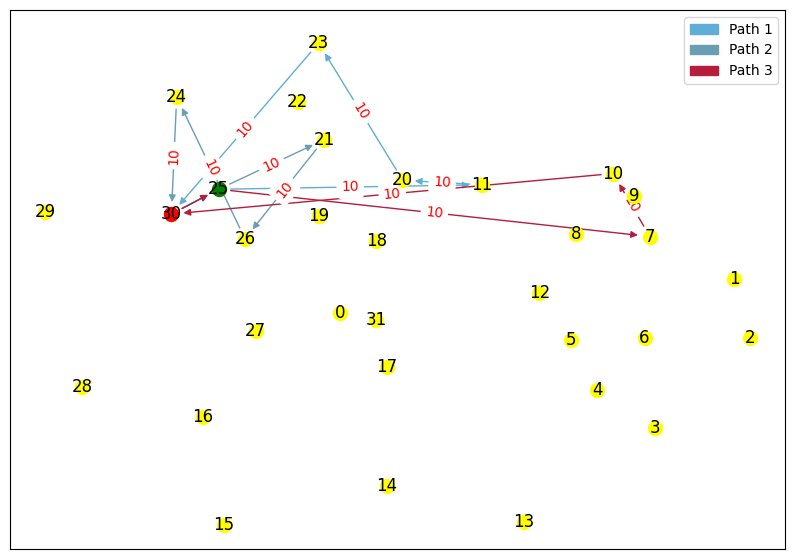

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def drawGraph(graph: Graph, solution):
    nbCustomers = len(graph.nodes)
    colors = ['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(len(solution))]
    plt.figure(figsize=(10, 7))    
    options = {
        'node_size': 100,
        'node_color': 'yellow',
    }

    G = nx.DiGraph()
    G.add_nodes_from(range(nbCustomers))
    pos = {i: (x, y) for i, (x, y) in enumerate(graph.nodes)}

    nx.draw_networkx_nodes(G, pos=pos, **options)
    nx.draw_networkx_labels(G, pos=pos)

    edge_labels = {} 

    for k, path in enumerate(solution):
        mapped_path = [graph.nodes.index(node) for node in path]
        truck_edges = [(mapped_path[i], mapped_path[i + 1]) for i in range(len(mapped_path) - 1)]
        truck_edges.append((mapped_path[-1], mapped_path[0]))
        nx.draw_networkx_edges(G, pos=pos, edgelist=truck_edges, edge_color=colors[k], label=f'Path {k + 1}')

        edge_labels.update({(mapped_path[i], mapped_path[i + 1]): f'{round(graph.profits[graph.nodes[i + 1]],1)}' for i in range(len(mapped_path) - 1)})

    nx.draw_networkx_nodes(G, pos=pos, nodelist=[graph.nodes.index(graph.start_point)], node_color='green', node_size=100)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[graph.nodes.index(graph.end_point)], node_color='red', node_size=100)

    colorbox = [mpatches.Patch(color=colors[k], label=f'Path {k + 1}') for k in range(len(solution))]
    plt.legend(handles=colorbox, loc='best')

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.show()

drawGraph(graph=graph_object,solution=ga.evolve())
#[[(14.3, 15.3), (8.7, 17.7), (7.4, 24.0), (8.2, 19.9), (4.9, 18.9)], [(14.3, 15.3), (11.2, 17.6), (11.2, 14.1), (7.3, 18.8), (4.9, 18.9)], [(14.3, 15.3), (11.2, 14.1), (13.2, 20.1), (4.9, 18.9)]]

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def drawGraph(graph: Graph, solution):
    solution=(solution,)
    nbCustomers = len(graph.nodes)
    colors = ['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(len(solution))]
    plt.figure(figsize=(10, 7))    
    options = {
        'node_size': 100,
        'node_color': 'yellow',
    }

    G = nx.DiGraph()
    G.add_nodes_from(range(nbCustomers))
    pos = {i: (x, y) for i, (x, y) in enumerate(graph.nodes)}

    nx.draw_networkx_nodes(G, pos=pos, **options)
    nx.draw_networkx_labels(G, pos=pos)

    edge_labels = {} 
    for k, path in enumerate(solution):
        print(path)
        mapped_path = [graph.nodes.index(node) for node in path]
        truck_edges = [(mapped_path[i], mapped_path[i + 1]) for i in range(len(mapped_path) - 1)]
        truck_edges.append((mapped_path[-1], mapped_path[0]))
        #print(f"Path {k + 1}:", path)
        nx.draw_networkx_edges(G, pos=pos, edgelist=truck_edges, edge_color=colors[k], label=f'Path {k + 1}')

        edge_labels.update({(mapped_path[i], mapped_path[i + 1]): f'{round(graph.profits[graph.nodes[i + 1]],1)}' for i in range(len(mapped_path) - 1)})

    nx.draw_networkx_nodes(G, pos=pos, nodelist=[0], node_color='green', node_size=100)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=[nbCustomers-1], node_color='red', node_size=100)

    colorbox = [mpatches.Patch(color=colors[k], label=f'Path {k + 1}') for k in range(len(solution))]
    plt.legend(handles=colorbox, loc='best')

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.show()

print(solution)
print(ga.population)
drawGraph(graph_object,best_solution)

NameError: name 'solution' is not defined